In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
events = pd.read_csv('C:/Zeaul/minordata/events.csv')
info = pd.read_csv('C:/Zeaul/minordata/ginf.csv')

In [3]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')

In [4]:
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

In [5]:
shots = events[events.event_type==1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

C:\Users\zeaat\AppData\Local\Temp\ipykernel_8336\2764275298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player'] = shots['player'].str.title()
C:\Users\zeaat\AppData\Local\Temp\ipykernel_8336\2764275298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player2'] = shots['player2'].str.title()
C:\Users\zeaat\AppData\Local\Temp\ipykernel_8336\2764275298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [6]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [7]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

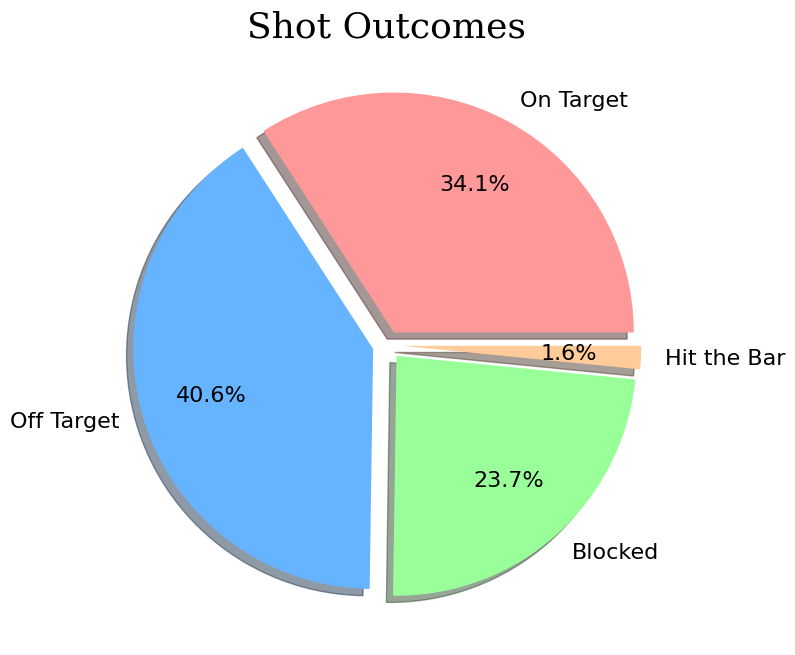

In [8]:
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

We see that most of the shots are off-target, but the difference with on-target shows is not so large. Of course only a fraction of those on-target shots end up as goals, because there is a goalkeeper trying to prevent goals on the other side.

Now let's explore where shots tend to be placed by the players.

In [9]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})
bar.shot_place = bar.shot_place.astype(int)
bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

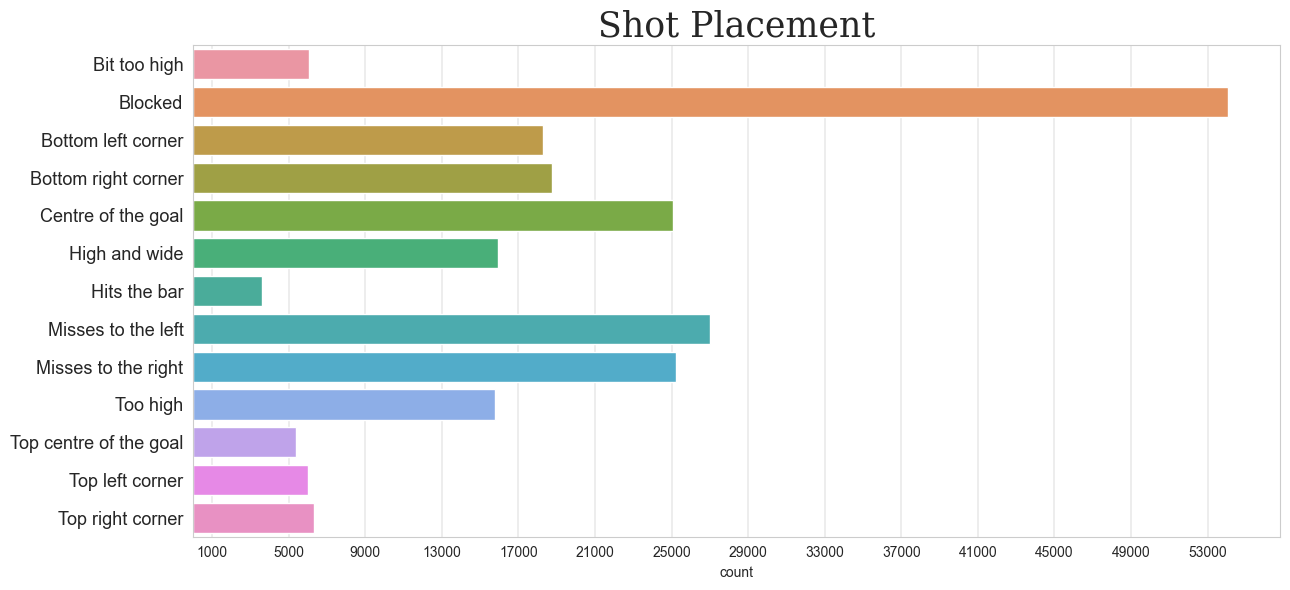

In [10]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

We find that the majority of shots are blocked by opponents, but this is because all the not-blocked shots are grouped into many different categories. We have seen in the previous pie chart that in fact 24% of the shots are indeed blocked, which is still quite a high percentage.

From the shots that are not blocked, we see that the majority are either directed at the centre of the goal, or miss to the left or right side.

Now we'll explore something that will be quite important for our xG model: which percentage of shots end up as goals. We'll divide this analysis for the different leagues and across years, to check if there are differences in the patterns through different parts of the world or different years.

In [11]:
goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [12]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

In [13]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y+2, value, ha="center", fontsize=14) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

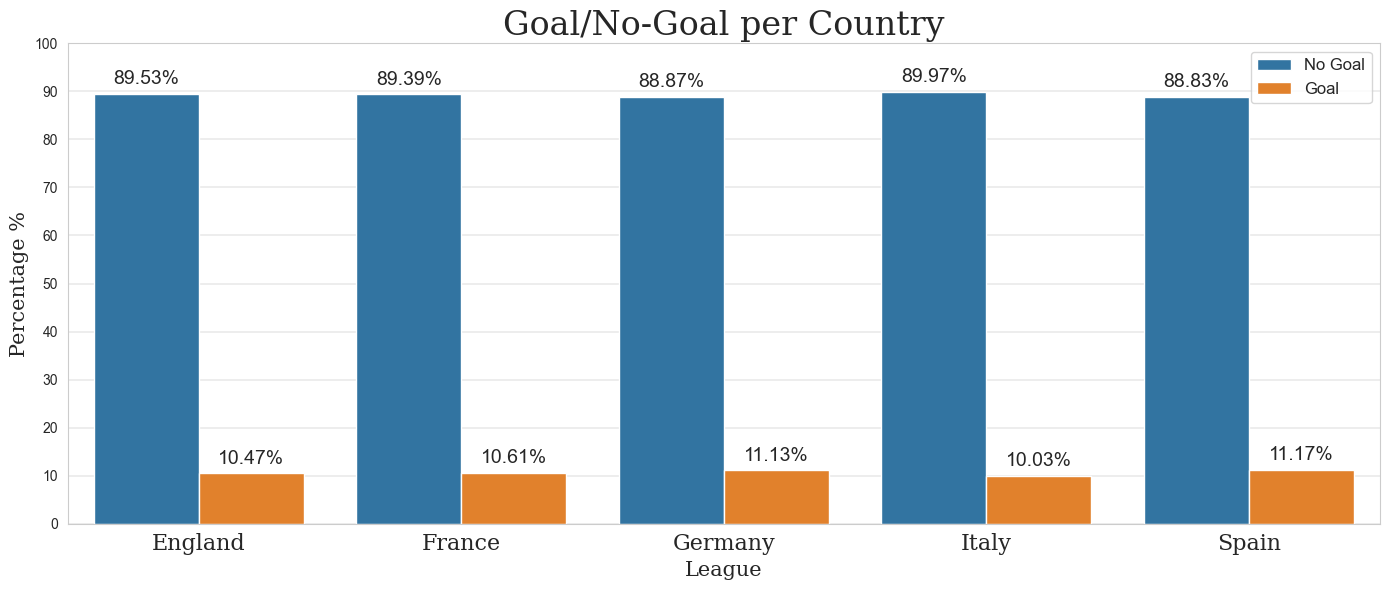

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='League', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Country", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

There are barely any differences across the different main leagues. It seems that any given shot has a 10-11% chance of being a goal anywhere in the world.

In [15]:
goals  = shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 'year']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [16]:
goals['percentage']=0
for i in range(len(goals)):
    for year in goals.year.unique():
        if goals.iloc[i,goals.columns.get_loc("year")]==year:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.year==year]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

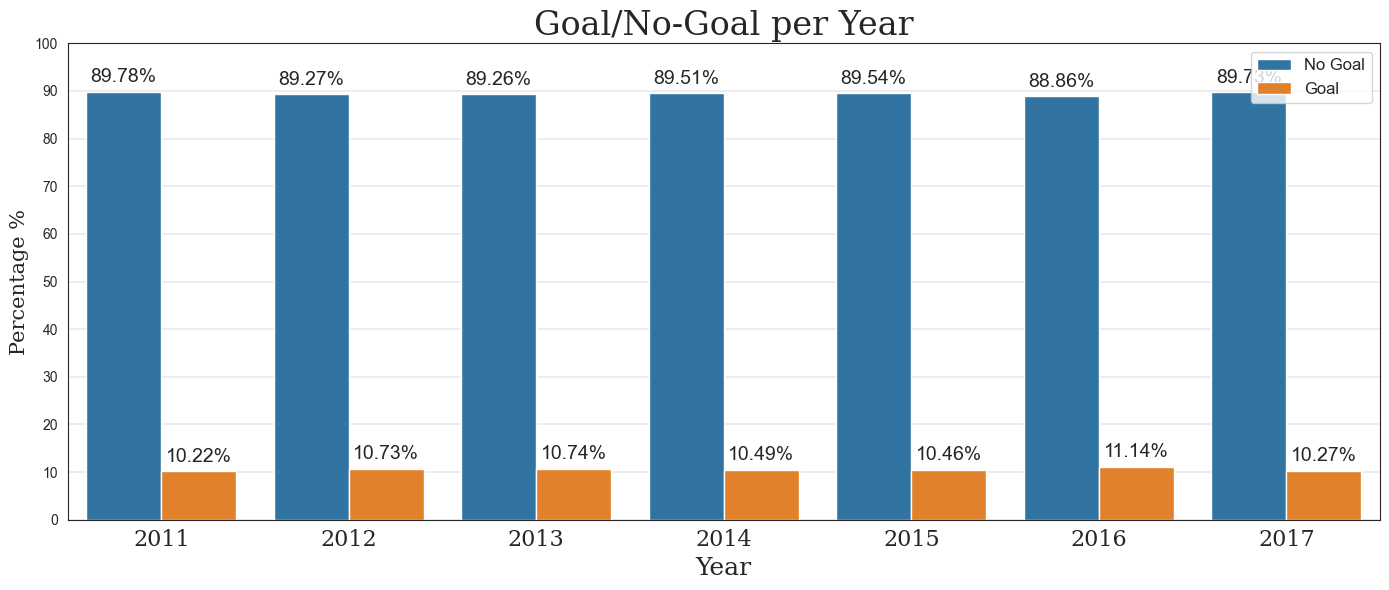

In [17]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Year', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Year", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

Again we find that the goal/no-goal ratios are nearly the same across time.

So it's becoming quite clear that statistically speaking 1 out of 9 to 10 shots are goals, no matter where or when you look at.

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('C:\Zeaul\minordata'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Zeaul\minordata\dictionary.txt
C:\Zeaul\minordata\events.csv
C:\Zeaul\minordata\ginf.csv
C:\Zeaul\minordata\MinorPh1 (1).pptx


In [19]:
#hide the warnings
import warnings
warnings.filterwarnings("ignore")

In [20]:
data = pd.read_csv('C:/Zeaul/minordata/events.csv')

In [21]:
data.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


In [22]:
data.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
      dtype='object')

In [23]:
txt = open("C:/Zeaul/minordata/dictionary.txt","r")

In [24]:
txt.read()

'event_type\n0\tAnnouncement\n1\tAttempt\n2\tCorner\n3\tFoul\n4\tYellow card\n5\tSecond yellow card\n6\tRed card\n7\tSubstitution\n8\tFree kick won\n9\tOffside\n10\tHand ball\n11\tPenalty conceded\n\n\nevent_type2\n12\tKey Pass\n13\tFailed through ball\n14\tSending off\n15\tOwn goal\n\n\nside\n1\tHome\n2\tAway\n\n\nshot_place\n1\tBit too high\n2\tBlocked\n3\tBottom left corner\n4\tBottom right corner\n5\tCentre of the goal\n6\tHigh and wide\n7\tHits the bar\n8\tMisses to the left\n9\tMisses to the right\n10\tToo high\n11\tTop centre of the goal\n12\tTop left corner\n13\tTop right corner\n\n\nshot_outcome\n1\tOn target\n2\tOff target\n3\tBlocked\n4\tHit the bar\n\n\nlocation\n1\tAttacking half\n2\tDefensive half\n3\tCentre of the box\n4\tLeft wing\n5\tRight wing\n6\tDifficult angle and long range\n7\tDifficult angle on the left\n8\tDifficult angle on the right\n9\tLeft side of the box\n10\tLeft side of the six yard box\n11\tRight side of the box\n12\tRight side of the six yard box\n13\t

In [25]:
#as we only focus on shots for this analysis, let's create another dataframe that only keeps the shot events
data_shot = data[data.event_type == 1]

In [26]:
messi = (data_shot.player == 'lionel messi')
ronaldo = (data_shot.player == 'cristiano ronaldo')

In [27]:
nb_shot_messi = data_shot.id_odsp[messi].count()
nb_goal_messi = data_shot.id_odsp[messi][data_shot.is_goal == 1].count()
ratio_messi = nb_goal_messi / nb_shot_messi

nb_shot_ronaldo = data_shot.id_odsp[ronaldo].count()
nb_goal_ronaldo = data_shot.id_odsp[ronaldo][data_shot.is_goal == 1].count()
ratio_ronaldo = nb_goal_ronaldo / nb_shot_ronaldo

print('Number of goals for Messi   : ', nb_goal_messi)
print('Goal/shot ratio for Messi   : ', ratio_messi)
print('Number of goals for Ronaldo : ', nb_goal_ronaldo)
print('Goal/shot ratio for Ronaldo : ', ratio_ronaldo)

Number of goals for Messi   :  205
Goal/shot ratio for Messi   :  0.22428884026258206
Number of goals for Ronaldo :  198
Goal/shot ratio for Ronaldo :  0.16638655462184873


We can notice here that Messi has a higher goal/shot ratio than Cristiano. This is a cool indicator that can be useful, but it doesn't tell the exact truth : is Messi better than Ronaldo in front of the goal? This kind of indicator isn't enough to say so.

In fact, this ratio lacks a decisive element : the difficulty of the shots taken. We can pretend that Messi has good teammates that do all the job for him and allow him to only score taps-in, while Ronaldo has to take harder shots, and thus has a lower ratio of goals/shot.

That's why we need another way of evaluating the performances of a striker : the Expected Goals (xG) are the perfect indicator for that.

The objective of the xG is to give a value to each shot, between 0 and 1. With a value of 0, the shot has almost no chance to go into the net, while with a value of 1 the shot is unmissable. To give you an idea, the xG value of a penalty is 0.77.


To perform our analysis and determine who's the best candidate for the role in our club, we are going to build our own xG model based on the dataset we have.

*Data cleaning*

First of all, we saw that some shot locations are not recorded (location == 19). Let's check if there is a lot of these N/A values or not.

In [28]:
print ('Number of shots not located : ', data_shot.is_goal[data.location == 19].count()) 
print ('Split by goal or no goal : ', data_shot.is_goal[data.location == 19].value_counts()) 
print('\
      ')
print('Number of shot recorded', data_shot.is_goal.count())

Number of shots not located :  1450
Split by goal or no goal :  is_goal
1    1438
0      12
Name: count, dtype: int64
      
Number of shot recorded 229135


We are going to drop those N/A values for the shot location, as they represent less than 6% of the goals.
Unfortunately almost all of them are goals, but we should have enough data.

Of course, at the end some players will see their number of goals decresead, but we judge it acceptable.

In [29]:
data_shot = data_shot[data_shot.location != 19]

In [30]:
data_shot.count()

id_odsp          227685
id_event         227685
sort_order       227685
time             227685
text             227685
event_type       227685
event_type2      167859
side             227685
event_team       227685
opponent         227685
player           227684
player2          167798
player_in             0
player_out            0
shot_place       226677
shot_outcome     227685
is_goal          227685
location         227685
bodypart         227685
assist_method    227685
situation        227685
fast_break       227685
dtype: int64

In the features that are interesting for us, we have no NaN or undefined values, so we can keep on going.

X/Y variables definition and train/test split
Here we pick our explanatory variables. The output, obviously, will be if the shot ends in the back of the net or not.

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
columns_to_convert = ['time', 'event_type', 'shot_place', 'location', 'is_goal', 'assist_method', 'shot_outcome', 'bodypart', 'situation', 'fast_break']
# Use the astype() method to convert the selected columns to float
data[columns_to_convert] = data[columns_to_convert].astype(float)
X = data_shot.loc[:,['time', 'side', 'event_type', 'shot_place', 'location', 'assist_method', 'shot_outcome', 'bodypart', 'situation', 'fast_break']]
y = data_shot.loc[:,['is_goal']]
imputer = SimpleImputer(strategy='most_frequent')
X_clean = imputer.fit_transform(X)
y_clean = imputer.fit_transform(y)
model = ExtraTreesClassifier()
model.fit(X_clean,y_clean)

ExtraTreesClassifier()

In [32]:
print(model.feature_importances_)

[0.20442565 0.00340003 0.         0.15593483 0.12664875 0.02457737
 0.29502069 0.01675717 0.13834863 0.03488689]


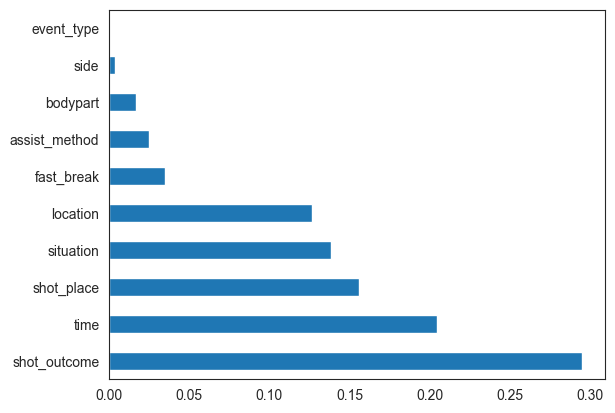

In [33]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [34]:
X = data_shot[['time', 'shot_place', 'bodypart', 'location', 'situation', 'assist_method', 'fast_break']]
y = data_shot['is_goal']

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, train_size = 0.8, stratify = y)

Try-on different models
Quick overview of some other classification models, to see if they can perform better than our K-nn

In [38]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    KNeighborsClassifier(),
    LinearSVC()]


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 93.3219%
RandomForestClassifier
****Results****
Accuracy: 93.4251%
AdaBoostClassifier
****Results****
Accuracy: 94.2355%
GradientBoostingClassifier
****Results****
Accuracy: 94.2530%
GaussianNB
****Results****
Accuracy: 76.2171%
LinearDiscriminantAnalysis
****Results****
Accuracy: 91.6793%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 85.8489%
KNeighborsClassifier
****Results****
Accuracy: 92.7356%
LinearSVC
****Results****
Accuracy: 92.5643%


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print('XGBoost model precision on test dataset : ', model.score(X_test, y_test) * 100)

XGBoost model precision on test dataset :  94.25302501262709


Give a value to each shot
The purpose of our model is to give a value to each shot. To do so, we are going to use the probability of a given shot to turn into a goal.

This can be found by using the predict_proba method on our dataset.

In [41]:
# add the probability to get 1 for every row as a new column
probas = model.predict_proba(X_clean)
data_shot['xgoalpercent'] = probas[:,1] ;

In [42]:
print('Maximum xG value for a shot : ', probas[:,1].max())
print('Minimum xG value for a shot : ', probas[:,1].min())

Maximum xG value for a shot :  0.998679482740999
Minimum xG value for a shot :  6.433740404317387e-05


In [43]:
nb_shot = data_shot.id_odsp[messi].count()
print('Lionel Messi :')
print('Number of shots for : ', nb_shot)

print('Expected goals for : ', data_shot[messi]['xgoalpercent'].sum(axis = 0))

nb_goal = data_shot.id_odsp[data_shot.is_goal == 1][messi].count()
print('Number of goals for : ', nb_goal)
print('Difference between goals and xG : ', nb_goal - data_shot[messi]['xgoalpercent'].sum(axis = 0))
print('xG/shots :', data_shot[messi]['xgoalpercent'].sum(axis = 0) / nb_shot)

print('\
    ')

nb_shot = data_shot.id_odsp[ronaldo].count()
print('Cristiano Ronaldo :')
print('Number of shots : ', nb_shot)

print('Expected goals : ', data_shot[ronaldo]['xgoalpercent'].sum(axis = 0))

nb_goal = data_shot.id_odsp[data_shot.is_goal == 1][ronaldo].count()
print('Number of goals : ', nb_goal)
print('Difference between goals and xG : ', nb_goal - data_shot[messi]['xgoalpercent'].sum(axis = 0))
print('xG/shots :', data_shot[messi]['xgoalpercent'].sum(axis = 0) / nb_shot)

Lionel Messi :
Number of shots for :  900
Expected goals for :  155.4212602018388
Number of goals for :  191
Difference between goals and xG :  35.578739798161195
xG/shots : 0.17269028911315423
    
Cristiano Ronaldo :
Number of shots :  1176
Expected goals :  165.56690822858053
Number of goals :  184
Difference between goals and xG :  28.578739798161195
xG/shots : 0.1321609355457813


We now have a much better comparison basis.

Based on the chances Messi had, an average player would have scored 131 goals, while the Argentinian scored 191. For Ronaldo, while an average player would have scored 151, the Portuguese scored 184.

Both players are over-performing, but Messi much more than Ronaldo : the difference is greater for Messi, eventhough he had less xG.

This is a solid argument if you want to proove that Messi is better than Ronaldo in front of the goal.

In [44]:
# we get the list of all the players, unique to make sure they only appear 1 time
list_of_players = data_shot.player.unique()
print(list_of_players)

['mladen petric' 'shinji kagawa' 'kevin grosskreutz' ... 'alhassan wakaso'
 'roman zozulia' 'alessandro bastoni']


In [45]:
comparison = pd.DataFrame(columns=['player', 'nb_shots', 'expected_goals', 'goals_scored', 'xg_dif', \
                                   'nb_headers', 'expected_head_goals', 'head_goals_scored', 'head_xg_dif', \
                                   'xg_per_shot', 'pct_goals_counter'])

In [46]:
comparison

,player,nb_shots,expected_goals,goals_scored,xg_dif,nb_headers,expected_head_goals,head_goals_scored,head_xg_dif,xg_per_shot,pct_goals_counter


In [47]:
for i in range(list_of_players.size):
    #get the player name
    player = list_of_players[i]
    #xg
    nb_shot = data_shot.id_odsp[data_shot.player == player].count()
    xg = data_shot[data_shot.player == player]['xgoalpercent'].sum(axis = 0)
    nb_goal = data_shot.id_odsp[data_shot.is_goal == 1][data_shot.player == player].count()
    xg_dif = nb_goal - xg
    #xg for headers
    nb_head = data_shot.id_odsp[data_shot.player == player][data_shot.bodypart == 3].count()
    xg_head = data_shot[data_shot.player == player][data_shot.bodypart == 3]['xgoalpercent'].sum(axis = 0)
    nb_goal_head = data_shot.id_odsp[data_shot.is_goal == 1][data_shot.bodypart == 3][data_shot.player == player].count()
    head_xg_dif = nb_goal_head - xg_head
    #xg/shot
    xg_per_shot = xg / nb_shot
    #counter-attacks
    nb_counter_goals = data_shot.id_odsp[data_shot.is_goal == 1][data_shot.fast_break == 1][data_shot.player == player].count()  
    pct_count_goals = nb_counter_goals / nb_goal * 100
    #append the player's row in the comparison dataframe
    comparison.loc[-1] = [player, nb_shot, xg, nb_goal, xg_dif, nb_head, xg_head, nb_goal_head, head_xg_dif, xg_per_shot, pct_count_goals]
    comparison.index = comparison.index + 1

In [48]:
comparison

,player,nb_shots,expected_goals,goals_scored,xg_dif,nb_headers,expected_head_goals,head_goals_scored,head_xg_dif,xg_per_shot,pct_goals_counter
4725,mladen petric,62.0,7.389209,5.0,-2.389209,8.0,0.013461,0.0,-0.013461,0.119181,20.000000
4724,shinji kagawa,151.0,20.935692,25.0,4.064308,13.0,1.550742,2.0,0.449258,0.138647,20.000000
4723,kevin grosskreutz,110.0,8.571131,9.0,0.428869,10.0,0.427020,0.0,-0.427020,0.077919,11.111111
4722,mats hummels,120.0,14.307295,9.0,-5.307295,80.0,8.041834,5.0,-3.041834,0.119227,0.000000
4721,tomas rincon,98.0,4.128272,3.0,-1.128272,2.0,0.001982,0.0,-0.001982,0.042125,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
4,jose gimenez,1.0,0.094987,0.0,-0.094987,1.0,0.094987,0.0,-0.094987,0.094987,NaN
3,mame thiam,1.0,0.000756,0.0,-0.000756,0.0,0.000000,0.0,0.000000,0.000756,NaN
2,alhassan wakaso,1.0,0.002028,0.0,-0.002028,1.0,0.002028,0.0,-0.002028,0.002028,NaN
1,roman zozulia,3.0,0.097761,0.0,-0.097761,3.0,0.097761,0.0,-0.097761,0.032587,NaN


In [52]:
selection = comparison[comparison.xg_dif >= 5][comparison.goals_scored >= 10][comparison.head_goals_scored >= 5][comparison.head_xg_dif >= 2][comparison.xg_per_shot >= 0.1][comparison.pct_goals_counter >= 10]
selection.sort_values(by='xg_dif', ascending=False)

,player,nb_shots,expected_goals,goals_scored,xg_dif,nb_headers,expected_head_goals,head_goals_scored,head_xg_dif,xg_per_shot,pct_goals_counter
2208,gareth bale,298.0,35.775314,47.0,11.224686,73.0,9.879027,14.0,4.120973,0.120051,12.765957
4082,antoine griezmann,491.0,67.812046,78.0,10.187954,78.0,10.075117,14.0,3.924883,0.138110,10.256410
